# Example to connect to postgres

This is a tutorial to connect to our PostgreSQL database using python.

First you need to install the following libraries:
- psycopg2
- python-dotenv

Then you need to create a file with the name ".env". This file will contain the connection information and your credentials. This is an example:

```
DB_HOST=host_name
DB_NAME=postgres
DB_USER=my_user
DB_PASSWORD=my_password
DB_PORT=5432
```

After that you´re all set. We will import your credentials and connect to the database.

In [126]:
import os
import pandas as pd
import numpy as np
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [76]:
# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [77]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

Now we can query our data (write sql code) and store it as a pandas dataframe

In [78]:
query_main="""
    select TO_TIMESTAMP(year || '-' || month || '-' || day || ' ' || hour || ':' || min, 'YYYY-MM-DD HH24:MI') AT TIME ZONE 'UTC' as ts,
    gridimport_wh - gridexport_wh as net_load  
    from agg.t_msb1m  
    where site = 64
"""
df_main = pd.read_sql_query(query_main, conn)


C:\Users\Zóra\AppData\Local\Temp\ipykernel_29796\4074366065.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_main = pd.read_sql_query(query_main, conn)


In [79]:
pd.set_option('display.max_columns', None)

df_main

,ts,net_load
0,2019-03-01 00:00:00,10.680
1,2019-03-01 00:15:00,7.320
2,2019-03-01 00:30:00,7.410
3,2019-03-01 00:45:00,7.630
4,2019-03-01 01:00:00,8.140
...,...,...
38048,2020-03-31 22:45:00,7.510
38049,2020-03-31 23:00:00,7.370
38050,2020-03-31 23:15:00,7.570
38051,2020-03-31 23:30:00,6.810


In [80]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38053 entries, 0 to 38052
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ts        38053 non-null  datetime64[ns]
 1   net_load  38053 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 594.7 KB


## Convert Convert 'ts' to datetime and set as index

In [81]:
df_main['datetime'] = pd.to_datetime(df_main['ts'])
df_main.set_index('datetime', inplace=True)

In [82]:
df_main

,ts,net_load
datetime,,
2019-03-01 00:00:00,2019-03-01 00:00:00,10.680
2019-03-01 00:15:00,2019-03-01 00:15:00,7.320
2019-03-01 00:30:00,2019-03-01 00:30:00,7.410
2019-03-01 00:45:00,2019-03-01 00:45:00,7.630
2019-03-01 01:00:00,2019-03-01 01:00:00,8.140
...,...,...
2020-03-31 22:45:00,2020-03-31 22:45:00,7.510
2020-03-31 23:00:00,2020-03-31 23:00:00,7.370
2020-03-31 23:15:00,2020-03-31 23:15:00,7.570


### Creating function for lagged net_load

In [83]:
#Creating function for lagged net_load

def create_lagged_features(df, lags):
    df_lagged = df.copy()
    for lag in lags:
        df_lagged[f'net_load_lag_{lag}'] = df_lagged['net_load'].shift(lag)
    # Remove rows with NaN values due to shifting
    df_lagged = df_lagged.dropna()
    return df_lagged

# Define your lags
lags = [1,2,3,96,192]
#lags = list(range(1, 197))
#lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 
        #31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 
        #61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 
        #91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 
        #111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 
        #131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 
        #151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 
        #171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 
        #191, 192, 193, 194, 195, 196]

# Prepare your dataset with lagged features
df_lagged = create_lagged_features(df_main, lags)

In [84]:
# N.o. lags can be tuned according to model performance
#number_of_lags = 196 
#for lag in range(1, number_of_lags + 1):
    #df_main[f'net_load_lag_{lag}'] = df_main['net_load'].shift(lag)

# Drop rows with NaN values created by lagging
#df_main.dropna(inplace=True)

#df_main.head()

#### get_input function

In [85]:
def get_input(ts, lags):
    # Assumes `ts` is a pandas Series
    return ts[[-1 - lag for lag in lags]].values.reshape(1, -1)

# A function that will prepare the feature vector for a single prediction 
# by selecting the appropriate lagged values from the time series data

#### Create a function that performs sequential predictions over a specified number of steps, using each prediction as input for the next

In [86]:
#def rolling_prediction(model, initial_ts, steps_ahead, lags):
    #ts = initial_ts.copy()
    #predictions = []

    #for i in range(steps_ahead):
        # Get the input for the current prediction
        #input_features = get_input(ts, lags)
        # Predict the next step and append to the time series
        #pred = model.predict(input_features)[0]
        #predictions.append(pred)
        #ts = ts.append(pd.Series([pred]), ignore_index=True)
        
    #return predictions

In [87]:
def rolling_prediction(model, initial_ts, steps_ahead, lags):
    # 'initial_ts' is expected to be a Pandas Series with enough past observations to cover all lags.
    # initial_ts needs to be a series with at least 192 past observations.
    #HOW DO I MAKE SURE THSI IS THE CASE? I only have now lags 1,2,3,96,192
    ts = initial_ts.copy()
    predictions = []

    for i in range(steps_ahead):
        # Get the input for the current prediction.
        # Ensure that 'get_input' retrieves the last known observations from 'ts'
        # for all required lags.
        input_features = get_input(ts, lags)
        
        # Predict the next step using the RF model.
        pred = model.predict(input_features)[0]
        
        # Append the prediction to the list of predictions.
        predictions.append(pred)
        
        # Also append the prediction to 'ts' for subsequent predictions.
        # The 'ts' will now include the most recent prediction at the end.
        ts = ts.append(pd.Series(pred), ignore_index=True)
        
    # Return only the predictions made, not the entire series.
    return predictions

#### Create initial_ts by taking the last 192 observations from this point backward to cover all lags

In [89]:
# Assuming 'df_main' has a DateTimeIndex and 'net_load' is your target column.

# Identify the time point for initial_ts
end_time = df_main.index[-1]
start_time = end_time - pd.Timedelta(hours=48)  # 192 intervals of 15 minutes is equivalent to 48 hours

# Make sure you don't go out of bounds
if start_time < df_main.index[0]:
    raise ValueError("Not enough data points for the required lags.")

# Create initial_ts for rolling predictions
# We select the data between 'start_time' and 'end_time', including all necessary lags.
initial_ts = df_main.loc[start_time:end_time]['net_load']

In [106]:
initial_ts

datetime
2020-03-30 00:00:00    7.230
2020-03-30 00:15:00    7.740
2020-03-30 00:30:00    7.720
2020-03-30 00:45:00    7.260
2020-03-30 01:00:00    7.330
                       ...  
2020-03-31 22:45:00    7.510
2020-03-31 23:00:00    7.370
2020-03-31 23:15:00    7.570
2020-03-31 23:30:00    6.810
2020-03-31 23:45:00    9.225
Name: net_load, Length: 192, dtype: float64

### Define features and target, train and test

In [95]:
# Define features and target
y = df_lagged['net_load']
X = df_lagged[[f'net_load_lag_{lag}' for lag in lags]]

# Split data into training and testing sets
#train_size = int(len(df_lagged) * 0.8)
#train_features, test_features = X.iloc[:train_size], X.iloc[train_size:]
#train_target, test_target = y.iloc[:train_size], y.iloc[train_size:]

# Reserve the last 96 observations for testing
train_features = X.iloc[:-96]
test_features = X.iloc[-96:]

train_target = y.iloc[:-96]
test_target = y.iloc[-96:]



### Model definition and training 

In [115]:
rf = RandomForestRegressor()

# TRAIN the model
rf.fit(train_features, train_target)

# TEST the model - Predict on the test set - Make predictions for the test set
y_pred = rf.predict(test_features)


In [116]:
# error metric MAE and normalized MAE
mae = mean_absolute_error(test_target, y_pred)
print(f'Mean Absolute Error: {mae}')

target_range = train_target.max() -train_target.min()
normalized_mae = mae / target_range
print(f'Normalized MAE: {normalized_mae}')

Mean Absolute Error: 31.246124389033955
Normalized MAE: 0.01818114999943789


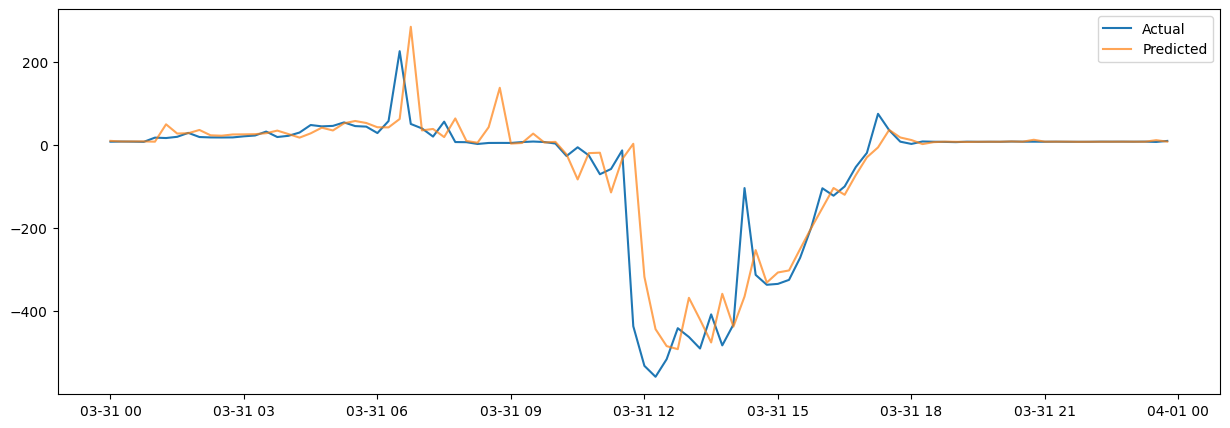

In [117]:
plt.figure(figsize=(15, 5))
plt.plot(test_target.index, test_target, label='Actual')
plt.plot(test_target.index, y_pred, label='Predicted', alpha=0.7)
plt.legend()
plt.show()

In [114]:
initial_ts

datetime
2020-03-30 00:00:00    7.230
2020-03-30 00:15:00    7.740
2020-03-30 00:30:00    7.720
2020-03-30 00:45:00    7.260
2020-03-30 01:00:00    7.330
                       ...  
2020-03-31 22:45:00    7.510
2020-03-31 23:00:00    7.370
2020-03-31 23:15:00    7.570
2020-03-31 23:30:00    6.810
2020-03-31 23:45:00    9.225
Name: net_load, Length: 192, dtype: float64

### Updated get_input function

In [118]:
def get_input(ts, lags):
    # Assumes `ts` is a pandas Series
    # Extracts the lag values based on the DateTime index
    input_vals = [ts[ts.index[-1] - pd.Timedelta(minutes=15*lag)] for lag in lags]
    return np.array(input_vals).reshape(1, -1)

# A function that will prepare the feature vector for a single prediction 
# by selecting the appropriate lagged values from the time series data

### Updated rolling_prediction function

In [123]:
#def rolling_prediction(model, initial_ts, steps_ahead, lags):
    # 'initial_ts' is expected to be a Pandas Series with DateTime index
    #ts = initial_ts.copy()
    #predictions = []
    #current_time = ts.index[-1]

    #for i in range(steps_ahead):
        #input_features = get_input(ts, lags)
        
        # Predict the next step using the RF model
        #pred = model.predict(input_features)[0]
        
        # Append the prediction to the list of predictions
        #predictions.append(pred)
        
        # Append the prediction to 'ts' for subsequent predictions
        # Here, the index is incremented by 15 minutes for each step
        #current_time += pd.Timedelta(minutes=15)
        #ts = ts.append(pd.Series([pred], index=[current_time]))
        
    #return predictions

In [131]:
def rolling_prediction(model, initial_ts, steps_ahead, lags):
    # 'initial_ts' is expected to be a Pandas Series with DateTime index
    ts = initial_ts.copy()
    predictions = []
    last_timestamp = ts.index[-1]

    for i in range(steps_ahead):
        # Construct the input feature array with the correct lags
        input_features = np.array([ts[ts.index[-lag]] for lag in lags]).reshape(1, -1)

        # Predict the next step and store the prediction
        pred = model.predict(input_features)[0]
        predictions.append(pred)

        # Calculate the next timestamp by adding the 15-minute interval
        next_timestamp = last_timestamp + pd.Timedelta(minutes=15)
        
        # Append the new prediction to the series with the correct timestamp
        ts[next_timestamp] = pred

        # Update the last timestamp
        last_timestamp = next_timestamp

    return predictions

In [132]:
predicted_next_day = rolling_prediction(rf, initial_ts, 96, lags)

C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:

In [134]:
actual_next_day_index_start = df_main.index.get_loc(initial_ts.index[-1]) + 1
actual_next_day_index_end = actual_next_day_index_start + 96

# Make sure you do not go out of the DataFrame bounds
if actual_next_day_index_end > len(df_main):
    raise ValueError("There aren't enough actual values in the data frame for the next day.")

actual_next_day = df_main.iloc[actual_next_day_index_start:actual_next_day_index_end]['net_load']

ValueError: There aren't enough actual values in the data frame for the next day.

In [133]:
if len(test_features) > 192:
    # Select the starting point for the prediction - the last row of the test set
    starting_point = test_features.iloc[-193:]
    # We will reshape this to comply with the expected input shape for the model
    initial_ts = starting_point.values.flatten()

    # Generate rolling predictions for the next 96 steps (one day ahead)
    predictions = rolling_prediction(rf, pd.Series(initial_ts), 96, lags)

    # Plot the actual vs predicted values for this day
    actual = test_target.iloc[-96:]  # Actual values for the last day in the test set
    plt.figure(figsize=(15, 5))
    plt.plot(range(96), actual, label='Actual')
    plt.plot(range(96), predictions, label='Predicted', alpha=0.7)
    plt.legend()
    plt.title('Day-Ahead Predictions vs Actual')
    plt.show()
else:
    print("Not enough data to perform rolling prediction for one day ahead.")

Not enough data to perform rolling prediction for one day ahead.
